Obtain the probability distributions of the time required to hit either absorbing barrier for a leaky integrator.

(-2, 1)

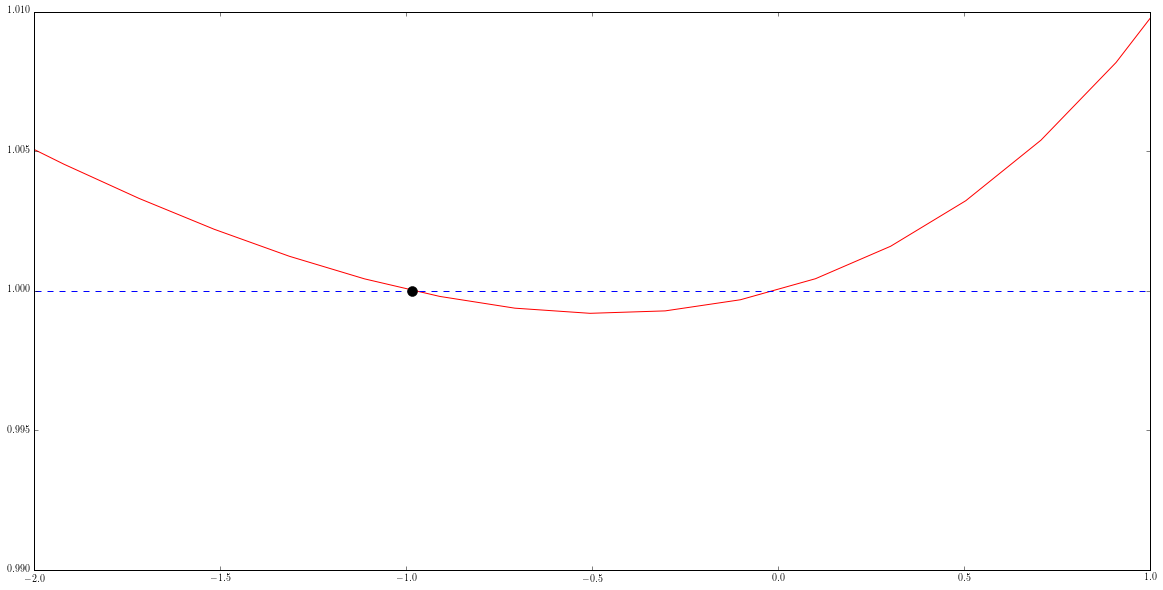

In [155]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import fsolve

#parameters
#tested intensities and actual intensity
L1 = 10.; L2 = 20.; L = 20.
#time step length
dt = .001
#absorbing barriers surrounding initial sum
a = 1.; b = -.3

#get the MGF of the stochastic process
x = np.linspace(-10,10,100)
MGF = np.exp((np.log(L2/L1) - (L2-L1)*dt)*x) * (1 - np.exp(-L*dt)) + \
    np.exp(-(L2-L1)*dt*x) * (np.exp(-L*dt))
#expectation on a timestep
EX = (np.log(L2/L1) - (L2-L1)*dt) * (1 - np.exp(-L*dt)) - (L2-L1)*dt * np.exp(-L*dt)

#get the nonzero root h0.
#define the MGF as an anonymous function:
f = lambda h: np.exp((np.log(L2/L1) - (L2-L1)*dt)*h) * (1 - np.exp(-L*dt)) + \
    np.exp(-(L2-L1)*dt*h) * (np.exp(-L*dt)) - 1

#the sign of the nonzero root depends on whether the expectation is positive or negative.
#initialize the root finder on one side of zero, depending on the sign of the expectation.
h_init = -10 * (EX > 0) + 10 * (EX < 0)
h0 = fsolve(f,h_init)[0];

#now get the absorption probabilities
alpha = (1-np.exp(b*h0))/(np.exp(a*h0) - np.exp(b*h0)); beta = 1 - alpha

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

plt.plot(x,MGF,'r')
plt.plot(x,np.ones(x.shape),'b--')
plt.plot(h0,1,'k.',markersize=20)
plt.ylim([.99,1.01])
plt.xlim([-2,1])

To get the characteristic function for absorption time, we need BOTH roots of:

\begin{equation*}
-\log(\phi(h)) = \tau
\end{equation*}

where $\tau$ is a purely imaginary variable.

The problem is that fsolve doesn't handle complex numbers.  So define a function that returns the real and imaginary parts of the MGF and optimize both simultaneously.

In [247]:
from numpy import *
import matplotlib

#the range of the free variable
t_max = np.max(-np.log(MGF)) - 1e-10; t_min = -t_max
#t = np.linspace(t_min, t_max, 10)
t = np.linspace(-.08,.08,10000)

#you are now going to find the roots of:
#    -log(MGF) = tau
#for every value of t.
#t1 refers to the root that passes through 0.  t2 refers to the root that passes through h0.
roots = np.zeros((2*len(t),2));

for r in range(2):
    
    #initialize the first iteration.  this is how fsolve finds both roots.
    if r == 0:
        h_init = np.array([400,-1])
    elif r == 1:
        h_init = np.array([-400,-1])
    i=0
    for tau in t:

        #h is a complex number with real and imaginary parts.
        #log_MGF returns complex scalar.
        def log_MGF(h,tau):
            return np.log(np.exp((np.log(L2/L1) - (L2-L1)*dt)*h) * (1 - np.exp(-L*dt)) + \
                         np.exp(-(L2-L1)*dt*h) * (np.exp(-L*dt))) + tau*1j

        #x1 is a real vector, with first entry the real part and second entry imaginary.
        def real_log_MGF(h1,tau):
            #converts a real-valued vector of size 2 to a complex number of size 1
            #outputs a real-valued vector of size 2
            h = h1[0] + 1j*h1[1]
            actual_log_MGF = log_MGF(h,tau)
            return [real(actual_log_MGF),imag(actual_log_MGF)]

        #find roots
        roots[r*len(t)+i] = fsolve(real_log_MGF,h_init,args=(tau,),xtol=1e-15); 
        h_init = roots[r*len(t)+i]; i+=1



(-0.74550279800034625, 0.74550279800034636)

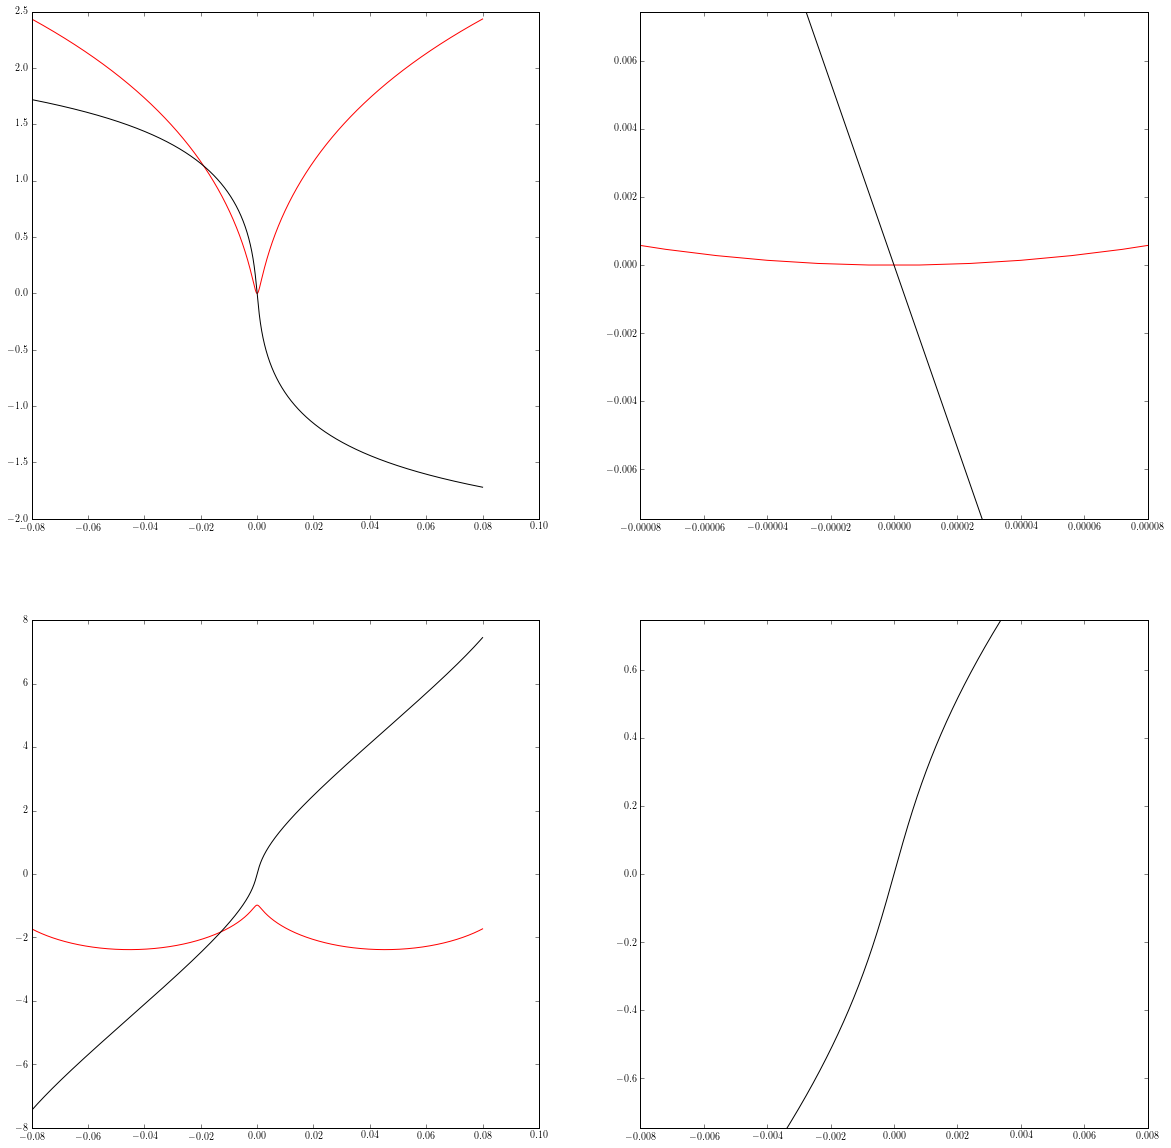

In [248]:
#print the results of the rootfinder.

matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)   

plt.subplot(2,2,1)
plt.plot(t,roots[0:len(t),0],'r')
plt.plot(t,roots[0:len(t),1],'k')

f = 1e-3
plt.subplot(2,2,2)
plt.plot(t,roots[0:len(t),0],'r')
plt.plot(t,roots[0:len(t),1],'k')
plt.xlim([np.min(t)*f,np.max(t)*f])
plt.ylim([np.min(roots)*f,np.max(roots)*f])

plt.subplot(2,2,3)
plt.plot(t,roots[len(t)::,0],'r')
plt.plot(t,roots[len(t)::,1],'k')

f = 1e-1
plt.subplot(2,2,4)
plt.plot(t,roots[len(t)::,0],'r')
plt.plot(t,roots[len(t)::,1],'k')
plt.xlim([np.min(t)*f,np.max(t)*f])
plt.ylim([np.min(roots)*f,np.max(roots)*f])

We see that the first root (the top two plots) is the root that passes through 0, i.e. t1.
The other is t2.

Now get the conditional characteristic functions and plot them.

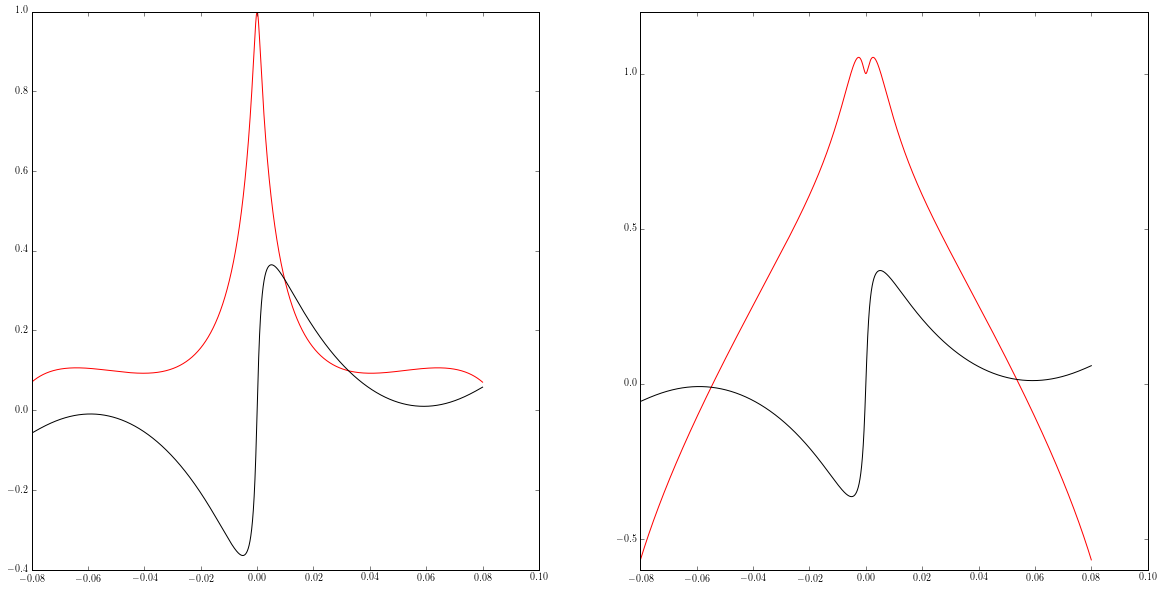

In [251]:
t1 = roots[0:len(t),0] + roots[0:len(t),1] * 1j
t2 = roots[len(t)::,0] + roots[len(t)::,1] * 1j

cfa = alpha*np.exp(a*t2) + (1-alpha)*np.exp(b*t2)*np.exp(t1*(b-a))
cfb = (alpha*np.exp(t1*(b-a))*np.exp(a*t2) + (1-alpha)*np.exp(b*t2))**(-1)

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)   

plt.subplot(1,2,1)
plt.plot(t,cfa.real,'r')
plt.plot(t,cfa.imag,'k')

plt.subplot(1,2,2)
plt.plot(t,cfb.real,'r')
plt.plot(t,cfa.imag,'k')

Now try to inverse transform to recover pdfs.

(0, 40)

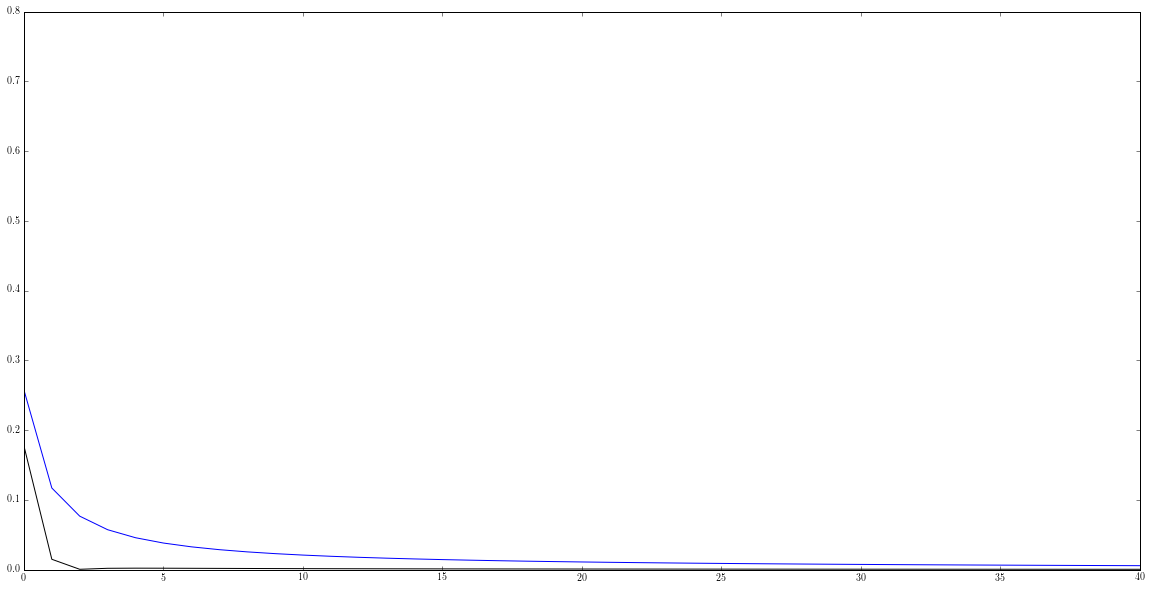

In [253]:
from scipy.fftpack import ifft

#number of points in freq space (make it odd)
n = 100001
#spacing of the points
dn = .01

#make your life easier with an odd number of datapoints
#multiply by 2*pi because these are FREQUENCIES to the ifft algorithm.
probfreq = 2 * np.pi * np.linspace(0,n,n,dtype=complex)

#now you want to pass cf into ifft, so rearrange the indices:
cfa_ifft = np.roll(cfa,(n-1)/2)

#pass to inverse fourier
pdfa_ifft = ifft(cfa_ifft).real

#and reverse-map to probability space
pdfa = np.roll(pdfa_ifft,(n-1)/2)

#now normalize the pdf:
#pdfa = float(n) * dn * pdfa

#now you want to pass cf into ifft, so rearrange the indices:
cfb_ifft = np.roll(cfb,(n-1)/2)

#pass to inverse fourier
pdfb_ifft = ifft(cfb_ifft).real

#and reverse-map to probability space
pdfb = np.roll(pdfb_ifft,(n-1)/2)

#now normalize the pdf:
#pdfb = float(n) * dn * pdfb

#now get RV space from your frequency space.
#this is valid for an odd number of samples (odd n)
rv = np.linspace(-1./(dn*n)*(n-1)/2, 1./(dn*n)*(n-1)/2, n)

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)   

plt.plot(np.abs(pdfa),'k')
plt.plot(np.abs(pdfb),'b')
plt.xlim([0,40])


In [225]:
print np.shape(pdfa), np.shape(probfreq)

(10000,) (1000001,)


In [239]:
print np.sum(pdfa), np.sum(pdfb)

0.0974806977589 0.0774623357216


In [227]:
np.min(probfreq)

0j